# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("DataQuest/NYC High School/schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("DataQuest/NYC High School/schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("DataQuest/NYC High School/schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

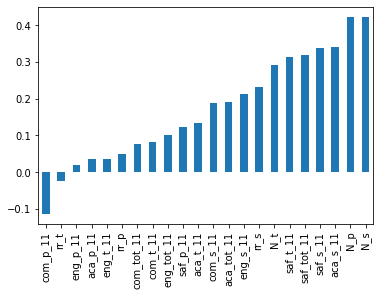

In [12]:
combined.corr()['sat_score'][survey_fields].sort_values().plot(kind='bar')

The highest correlations are between number of students/sat score and number of parents/sat score. Perhaps the parents who respond are more likely to be involved in student's schooling? The student's sat score is slightly negatively correlated with their communication score (as given by parents) but slightly positive as given by teachers. Students who's parents have high expectations of them are likely to do better on the sat as well. Perceived safety also correlated highly with scores.

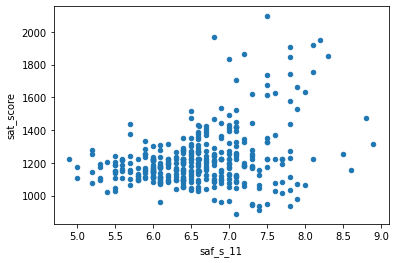

In [13]:
combined.plot('saf_s_11','sat_score', kind='scatter')

It does not seem like there is any major linear correlation between safety and sat scores, although there is a big jump at around 7.5 safety score indicating an exponential relationship.

In [14]:
import numpy as np
districts = combined.groupby('school_dist').agg(np.mean)

In [15]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = list(districts['lon'])
latitudes = list(districts['lat'])

Basemap.scatter(m, longitudes, latitudes, s=50, zorder=2, latlon=True,
                c = districts['saf_s_11'], cmap='summer')

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

Outer regions of NYC seem to be perceived as safer than inner regions. 

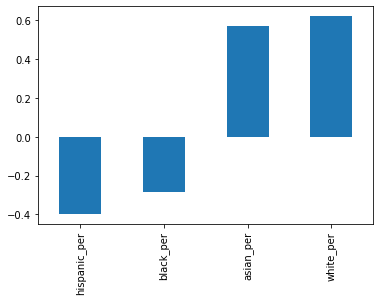

In [16]:
races = ['white_per','asian_per','black_per','hispanic_per']
combined.corr()['sat_score'][races].sort_values().plot(kind='bar')

White and Asian students seem to correlate highly with high sat scores. Black and Hispanic students correlate moderately negative with sat scores. This may be related to poverty.

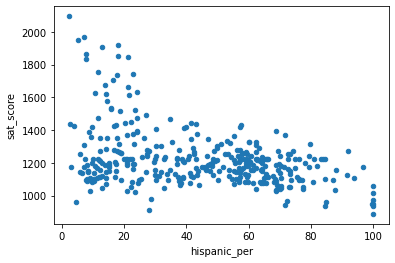

In [17]:
combined.plot('hispanic_per','sat_score',kind='scatter')

Hispanic students who make up >40% of a school do less well on sat scores than Hispanic students who arer a minority in their school.

In [18]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Source: https://www.usnews.com/education/best-high-schools/new-york/districts

|  | Economically Disadvantaged |
|---------------------------------------------------|----------------------------|
| MANHATTAN BRIDGES HIGH SCHOOL |  67% |
| WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL | 69% |
| GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M... | 94% |
| ACADEMY FOR LANGUAGE AND TECHNOLOGY | 98% |
| INTERNATIONAL SCHOOL FOR LIBERAL ARTS | 90% |
| PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE | 97% |
| MULTICULTURAL HIGH SCHOOL | 97% |
| PAN AMERICAN INTERNATIONAL HIGH SCHOOL | 91% |

Hispanics in majority-minority schools tend to come from economically disadvantaged backgrounds

In [19]:
combined[(combined['hispanic_per']<10) &
         (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Source: https://www.usnews.com/education/best-high-schools/new-york/districts

|  | Economically Disadvantaged |
|-----------------------------------------------------|----------------------------|
| STUYVESANT HIGH SCHOOL |  45% |
| BRONX HIGH SCHOOL OF SCIENCE | 43% |
| BROOKLYN TECHNICAL HIGH SCHOOL | 61% |
| QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE | 63% |
| STATEN ISLAND TECHNICAL HIGH SCHOOL | 39% |

Hispanics in a school with less economically disadvantaged tend to do better on sat scores.

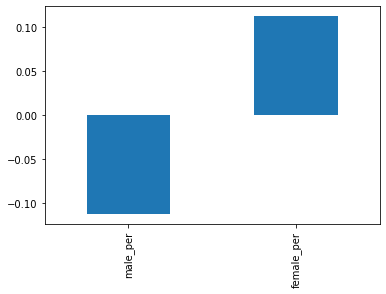

In [20]:
combined.corr()['sat_score'][['male_per','female_per']].plot(kind='bar')

Females correlate slightly positively and males slightly negatively with SAT scores.

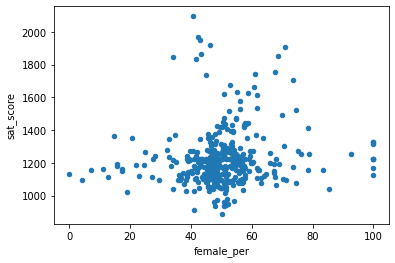

In [21]:
combined.plot('female_per','sat_score',kind='scatter')

Female students who do better at SATs tend to go to schools where females make up 40% or more of the population.

In [22]:
combined[(combined['female_per']>60) &
         (combined['sat_score'] > 1800)]['SCHOOL NAME']

5      BARD HIGH SCHOOL EARLY COLLEGE
302       TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Source: https://www.usnews.com/education/best-high-schools/new-york/districts

|  | Economically Disadvantaged | Minority Makeup|
|--------------------------------|----------------------------|
| BARD HIGH SCHOOL EARLY COLLEGE |  45% | 61%|
| TOWNSEND HARRIS HIGH SCHOOL | 54% | 78% |

High scoring female students who attend schools with a 60:40 gender ratio tend to be part of a more diverse cohort.

In [23]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

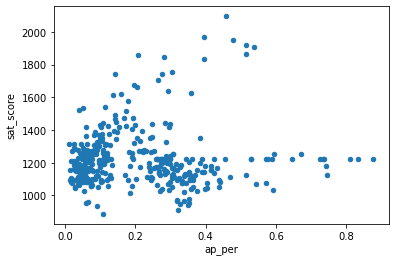

In [24]:
combined.plot('ap_per','sat_score',kind='scatter')

It looks like most schools' scores are <1500, but those that are >1500 tend to have between 20-60% of the population take the AP exams. This might mean that students who do well on the AP exams are encouraged to take the SAT exam as well.